In [1]:
import torch
torch.manual_seed(0)
from datagen import generate_shape_dataset

# example distribution: 10000 train, 5000 validation, 5000 test
dataset_size = 20000
image_size = 32

dataset_basic, labels_basic = generate_shape_dataset(
    num_examples=dataset_size, image_size=image_size, complex=False)
dataset_complex, labels_complex = generate_shape_dataset(
    num_examples=dataset_size, image_size=image_size, complex=True)

# we only want total number of examples to be 20000; ensure distribution of basic and complex examples is 50-50
dataset_combined = torch.cat((dataset_basic[:dataset_size//2], dataset_complex[:dataset_size//2]), dim=0)
labels_combined = torch.cat((labels_basic[:dataset_size//2], labels_complex[:dataset_size//2]), dim=0)

/Users/jonathoncarl/s24/cs381/curriculum-learning/datagen.py:210: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return tensor(dataset, dtype=torch.float32), tensor(labels, dtype=torch.long)


In [2]:
torch.save(dataset_basic, 'data/dataset_basic.pt')
torch.save(labels_basic, 'data/labels_basic.pt')
torch.save(dataset_complex, 'data/dataset_complex.pt')
torch.save(labels_complex, 'data/labels_complex.pt')
torch.save(dataset_combined, 'data/dataset_combined.pt')
torch.save(labels_combined, 'data/labels_combined.pt')

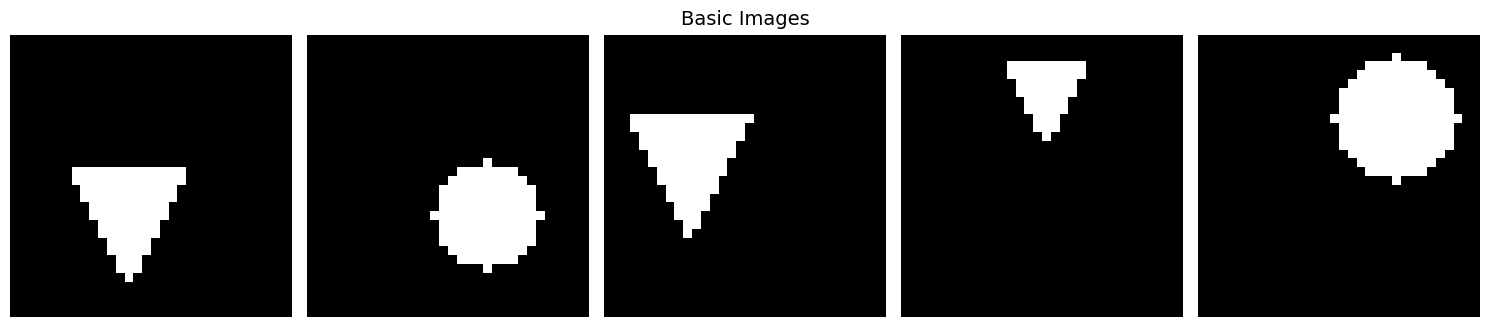

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# visualize a few examples
fig, axes = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):

    axes[i].imshow(dataset_basic[i], cmap='gray')
    axes[i].axis('off')

plt.suptitle('Basic Images', y=0.75, fontsize=14)

plt.tight_layout()
plt.show()

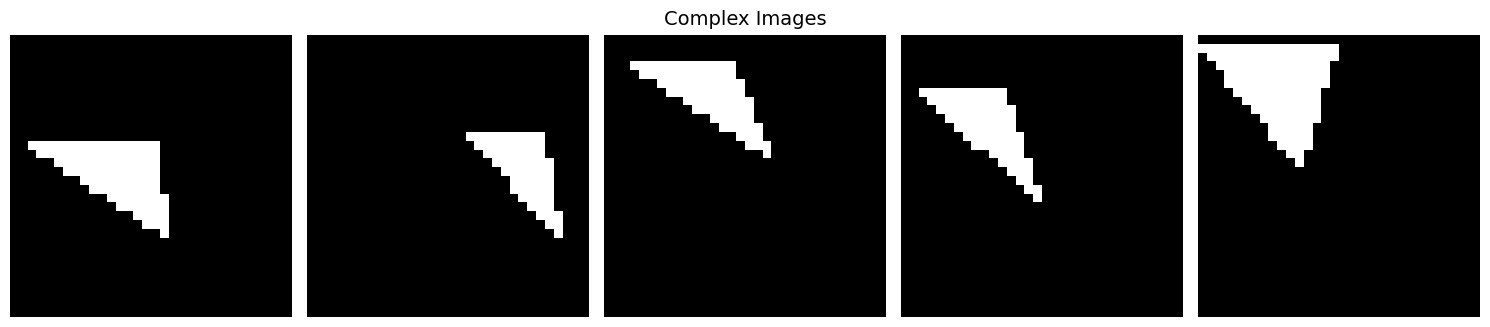

In [4]:
import time

fig, axes = plt.subplots(1, 5, figsize=(15, 6))

triangles = []
for i, label in enumerate(labels_complex.tolist()):

    if label == 1 and len(triangles) < 5:
        triangles.append(dataset_complex[i])

for i in range(5):

    axes[i].imshow(triangles[i], cmap='gray')
    axes[i].axis('off')


plt.suptitle('Complex Images', y=0.75, fontsize=14)
plt.tight_layout()
plt.show()

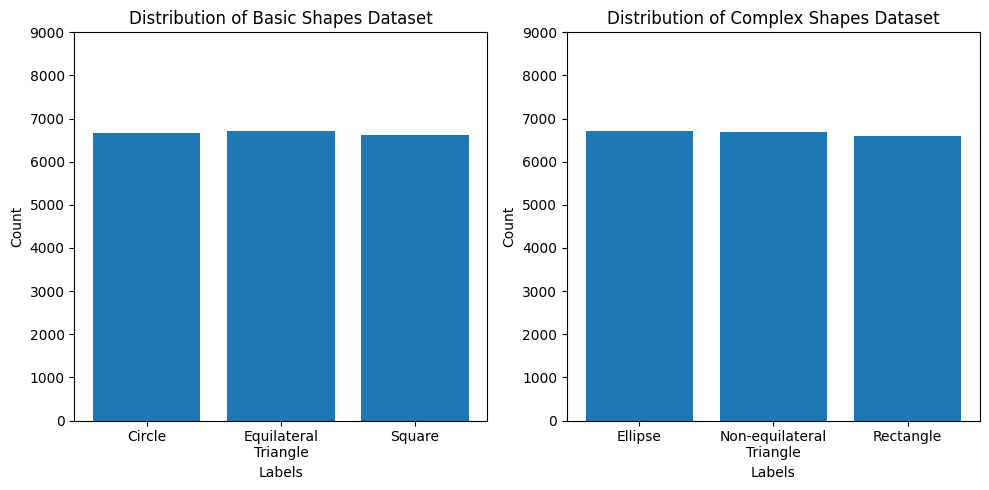

In [5]:
from collections import Counter

dataset_basic_counts = Counter(labels_basic.tolist())
dataset_complex_counts = Counter(labels_complex.tolist())
# Plotting the histograms
plt.figure(figsize=(10, 5))

# Plot histogram for Basic Shapes
plt.subplot(1, 2, 1)
plt.bar(dataset_basic_counts.keys(), dataset_basic_counts.values())
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(list(range(3)), ['Circle', 'Equilateral\nTriangle',
           'Square'])
plt.yticks(list(range(0, 10000, 1000)))
plt.title('Distribution of Basic Shapes Dataset')

# Plot histogram for Complex Shapes
plt.subplot(1, 2, 2)
plt.bar(dataset_complex_counts.keys(), dataset_complex_counts.values())
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(list(range(3)), ['Ellipse',
           'Non-equilateral\nTriangle', 'Rectangle'])
plt.yticks(list(range(0, 10000, 1000)))
plt.title('Distribution of Complex Shapes Dataset')

plt.tight_layout()
plt.show()

In [6]:
from datagen import prepare_data

num_classes= 3
batch_size = 100

train_loader_basic, val_loader_basic, test_loader_basic = prepare_data(
    dataset=dataset_basic, labels=labels_basic, batch_size=batch_size, num_classes=num_classes, shuffle=False)

train_loader_complex, val_loader_complex, test_loader_complex = prepare_data(
    dataset=dataset_complex, labels=labels_complex, batch_size=batch_size, num_classes=num_classes, shuffle=False)

train_loader_combined, val_loader_combined, test_loader_combined = prepare_data(
    dataset=dataset_combined, labels=labels_combined, batch_size=batch_size, num_classes=num_classes, shuffle=True)

In [7]:
from model import grid_search
import json, os

input_size = image_size * image_size

# Hyperparameters to tune
param_grid = {
    'hidden_sizes': [32, 64, 128, 256],
    'learning_rates' : [0.001, 0.01, 0.1]
}


file_path = 'models/optimal_hyperparameters.json'
best_params = None
if os.path.isfile(file_path):
    with open(file_path, 'r') as f:
        best_params = json.load(f)
else:
    # only run a grid search if we haven't yet determined optimal hyperparameters
    best_params, best_acc = grid_search(param_grid, train_loader_complex, input_size=input_size, val_loader=val_loader_complex)
    with open(file_path, 'w') as f:
        json.dump(best_params, f)
    print("Optimal hyperparameters saved to 'optimal_hyperparameters.json'.")

print("Optimal hyperparameters selected by maximizing complex validation accuracy.")
print(best_params)

Optimal hyperparameters selected by maximizing complex validation accuracy.
{'hidden_size': 128, 'learning_rate': 0.001}


In [8]:
from torch import nn, optim

hidden_size = best_params['hidden_size']
learning_rate = best_params['learning_rate']
ce_loss = nn.CrossEntropyLoss()
num_epochs = 256
input_size = image_size * image_size
save_model = False

Training basic model on basic data...


Model training has reached early stopping.


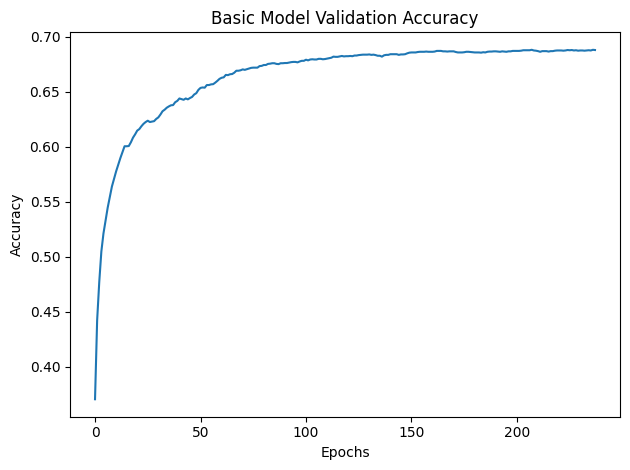

basic validation accuracy after training: 0.6878
Basic data training complete for basic model!


In [9]:
from model import FeedForward, train_model

model_basic = FeedForward(input_size=input_size,
                          hidden_size=hidden_size, output_size=num_classes)

optimizer_basic = optim.SGD(model_basic.parameters(), lr=learning_rate)

print("Training basic model on basic data...")
model_basic, _ = train_model(model=model_basic, loader=train_loader_basic,
                            loss_fn=ce_loss, optimizer=optimizer_basic,
                            num_epochs=num_epochs, verbose=False,
                            val_loader=val_loader_combined, model_type='basic',
                            plot_title='Basic Model Validation Accuracy')

print("Basic data training complete for basic model!")

In [ ]:
if save_model:
    torch.save(model_basic.state_dict(), 'models/model_basic.pth')

Training curriculum models...
Training curriculum model at switch epoch=0
Curriculum training on basic data complete. Now training curriculum model on complex data...


Model training has reached early stopping.


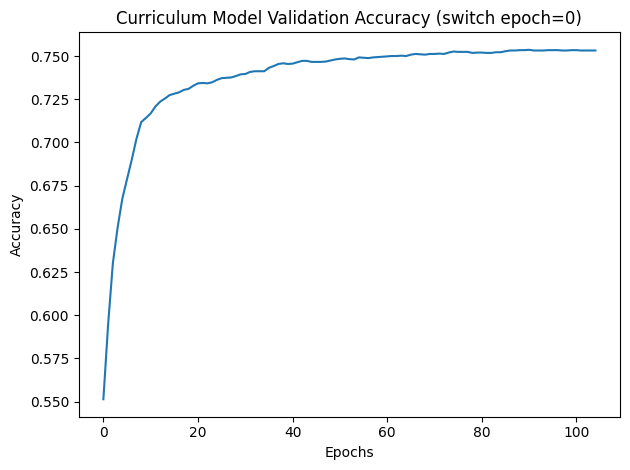

basic validation accuracy after training: 0.7532
Validation accuracy of model at switch epoch 0: 0.7532
Training curriculum model at switch epoch=2


Curriculum training on basic data complete. Now training curriculum model on complex data...


Model training has reached early stopping.


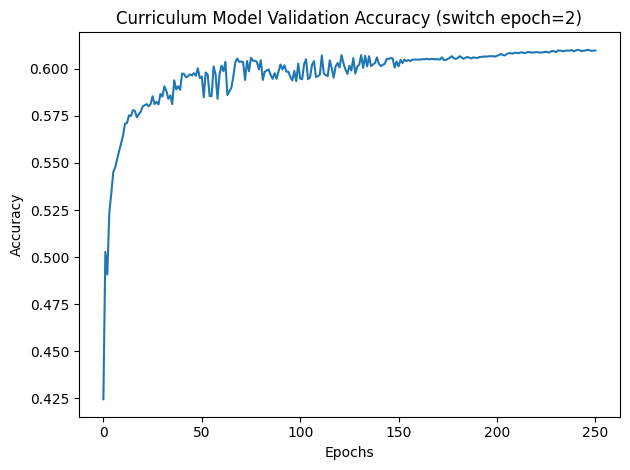

basic validation accuracy after training: 0.6096
Validation accuracy of model at switch epoch 2: 0.6096
Training curriculum model at switch epoch=4


Curriculum training on basic data complete. Now training curriculum model on complex data...


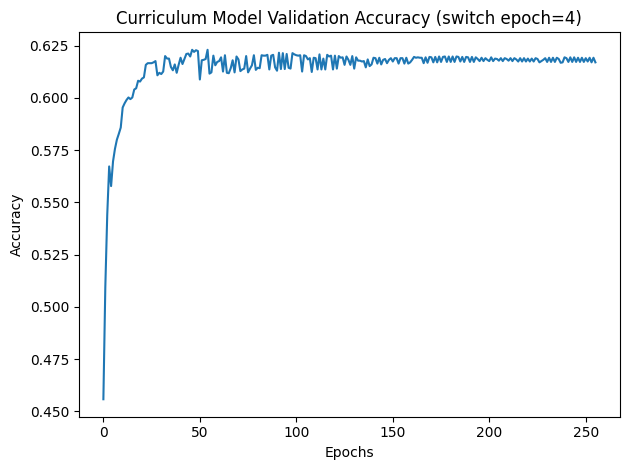

basic validation accuracy after training: 0.617
Validation accuracy of model at switch epoch 4: 0.617
Training curriculum model at switch epoch=8


Curriculum training on basic data complete. Now training curriculum model on complex data...


Model training has reached early stopping.


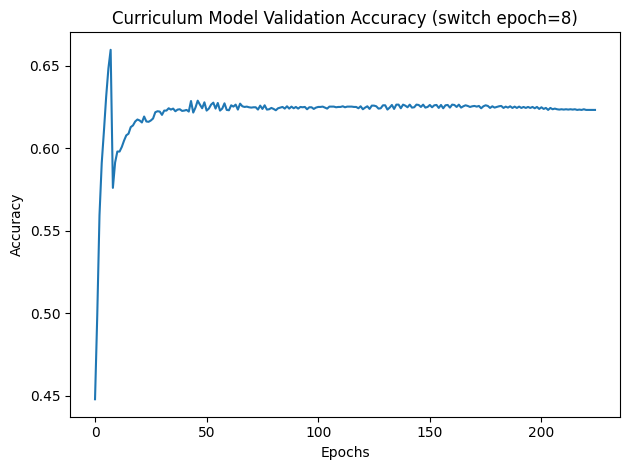

basic validation accuracy after training: 0.6232
Validation accuracy of model at switch epoch 8: 0.6232
Training curriculum model at switch epoch=16


Curriculum training on basic data complete. Now training curriculum model on complex data...


Model training has reached early stopping.


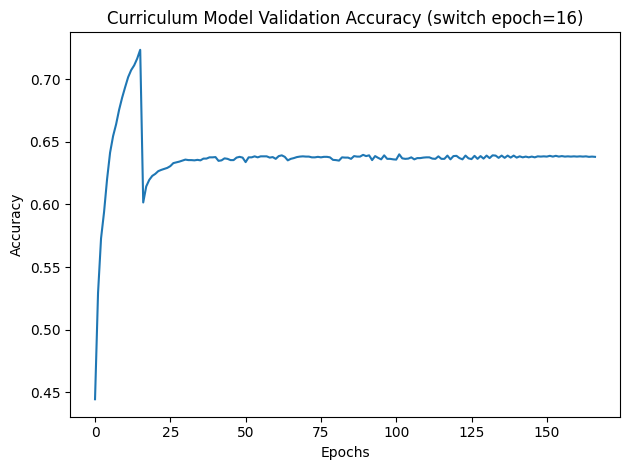

basic validation accuracy after training: 0.638
Validation accuracy of model at switch epoch 16: 0.638
Training curriculum model at switch epoch=32


Curriculum training on basic data complete. Now training curriculum model on complex data...


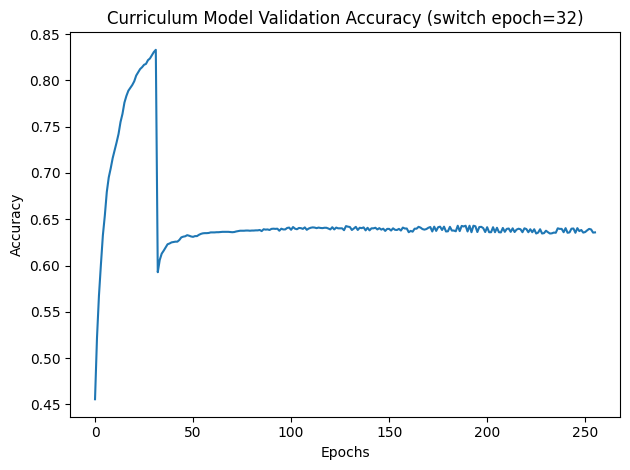

basic validation accuracy after training: 0.6358
Validation accuracy of model at switch epoch 32: 0.6358
Training curriculum model at switch epoch=64


Curriculum training on basic data complete. Now training curriculum model on complex data...


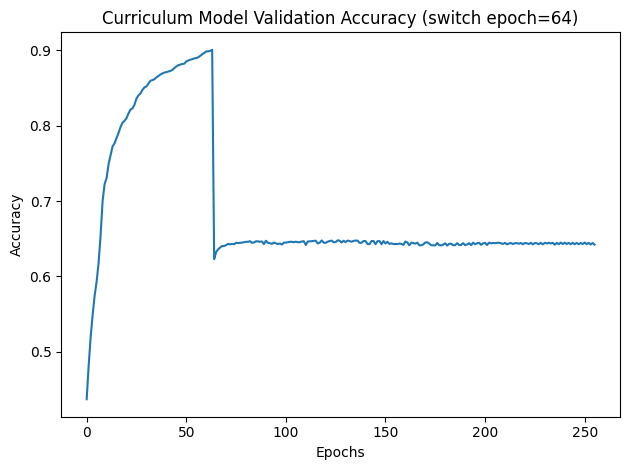

basic validation accuracy after training: 0.6422
Validation accuracy of model at switch epoch 64: 0.6422
Training curriculum model at switch epoch=128


Curriculum training on basic data complete. Now training curriculum model on complex data...


Model training has reached early stopping.


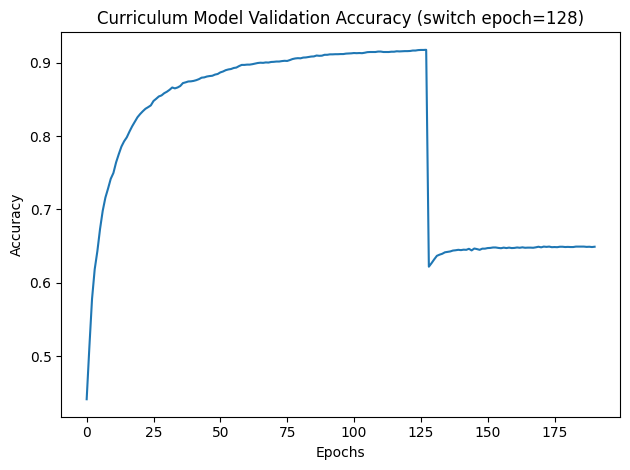

basic validation accuracy after training: 0.6492
Validation accuracy of model at switch epoch 128: 0.6492
All curriculum models completed training!


In [10]:
# train the curriculum model on the basic dataset first, then the complex one
print("Training curriculum models...")

currciulum_accs = []
for i in range(0, 7 + 1):

    model_curriculum = FeedForward(input_size=input_size,
                               hidden_size=hidden_size, output_size=3)
    optimizer_curriculum = optim.SGD(
        model_curriculum.parameters(), lr=learning_rate)

    switch_epoch = 0 if i == 0 else 2**i
    print(f'Training curriculum model at switch epoch={switch_epoch}')

    model_curriculum, acc = train_model(model=model_curriculum, loader=train_loader_basic,
                        loss_fn=ce_loss, optimizer=optimizer_curriculum, 
                        num_epochs=num_epochs, verbose=False, 
                        switch_loader=train_loader_complex,
                        val_loader=val_loader_combined,
                        model_type='curriculum',
                        switch_epoch=switch_epoch, plot_title=f'Curriculum Model Validation Accuracy (switch epoch={switch_epoch})')
    
    if save_model:
        torch.save(model_curriculum.state_dict(), f'models/model_curriculum_{switch_epoch}.pth')
    
    currciulum_accs.append(acc)

    print(f"Validation accuracy of model at switch epoch {switch_epoch}: {acc}")

print("All curriculum models completed training!")

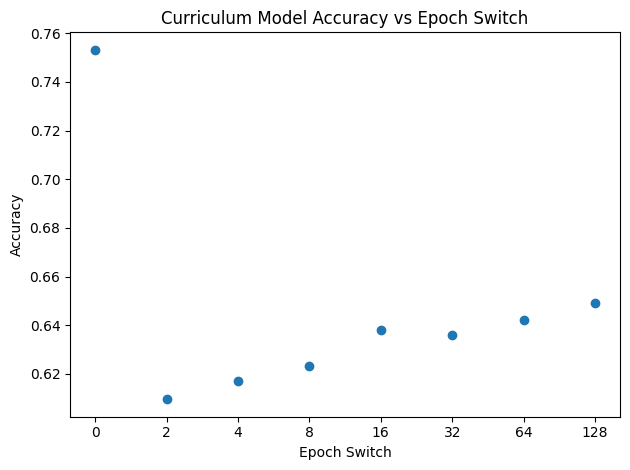

In [11]:
x_indices = list(range(8))
switch_epochs = [0] + [2**i for i in range(1, 8)]
plt.plot(x_indices, currciulum_accs, marker='o', linestyle='None')
plt.xlabel('Epoch Switch')
plt.ylabel('Accuracy')
plt.title('Curriculum Model Accuracy vs Epoch Switch')
plt.xticks(x_indices, switch_epochs)
plt.tight_layout()
plt.show()

Training complex model on complex data...


Model training has reached early stopping.


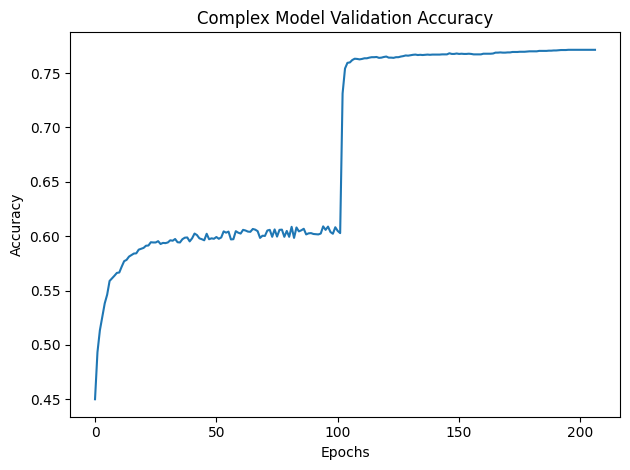

complex validation accuracy after training: 0.7714
Complex data training complete for complex model!


In [12]:
model_complex = FeedForward(input_size=input_size,
                            hidden_size=hidden_size, output_size=3)

optimizer_complex = optim.SGD(model_complex.parameters(), lr=learning_rate)

print("Training complex model on complex data...")

model_complex, _ = train_model(model=model_complex, loader=train_loader_complex,
                         loss_fn=ce_loss, optimizer=optimizer_complex, 
                         num_epochs=num_epochs, val_loader=val_loader_combined, 
                         verbose=False, model_type='complex', 
                         plot_title='Complex Model Validation Accuracy')

if save_model:
    torch.save(model_complex.state_dict(), 'models/model_complex.pth')

print("Complex data training complete for complex model!")

Training combined model on all data...


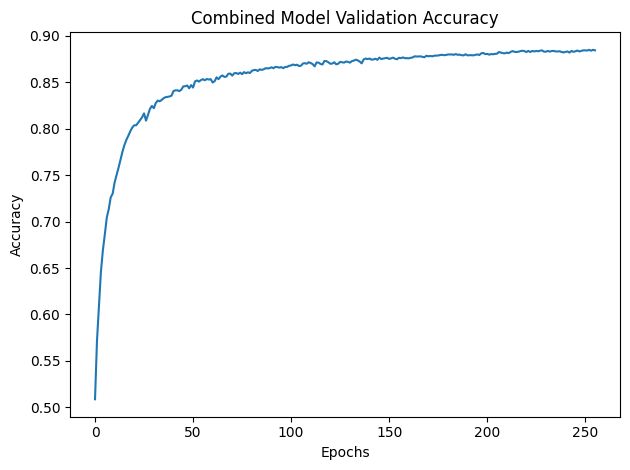

basic validation accuracy after training: 0.8842
Combined data training complete on combined model!


In [13]:
model_combined = FeedForward(input_size=input_size,
                             hidden_size=hidden_size, output_size=3)

optimizer_combined = optim.SGD(
    model_combined.parameters(), lr=learning_rate)

print("Training combined model on all data...")

model_combined, _ = train_model(model=model_combined, loader=train_loader_combined,
                             loss_fn=ce_loss, optimizer=optimizer_combined, num_epochs=num_epochs,
                             val_loader=val_loader_combined, verbose=False, plot_title='Combined Model Validation Accuracy')

if save_model:
    torch.save(model_combined.state_dict(), 'models/model_combined.pth')

print("Combined data training complete on combined model!")

In [15]:
from model import eval_model

model_basic = FeedForward(input_size=input_size, hidden_size=hidden_size, output_size=3)
model_curriculum = FeedForward(input_size=input_size, hidden_size=hidden_size, output_size=3)
model_complex = FeedForward(input_size=input_size, hidden_size=hidden_size, output_size=3)
model_combined = FeedForward(input_size=input_size, hidden_size=hidden_size, output_size=3)

model_basic.load_state_dict(torch.load('models/model_basic.pth'))

# choose curriculum model that has highest accuracy
best_idx = currciulum_accs.index(max(currciulum_accs))
best_acc = 0 if best_idx == 0 else 2 ** best_idx

model_curriculum.load_state_dict(torch.load(f'models/model_curriculum_{best_acc}.pth'))
model_complex.load_state_dict(torch.load('models/model_complex.pth'))
model_combined.load_state_dict(torch.load('models/model_combined.pth'))

# base model performance on combined data
basic_test_acc = eval_model(model=model_basic, loader=test_loader_combined, model_type='basic', verbose=True)
curriculum_test_acc = eval_model(model=model_curriculum, loader=test_loader_combined, model_type='curriculum', verbose=True)
complex_test_acc = eval_model(model=model_complex, loader=test_loader_combined, model_type='complex', verbose=True)
combined_test_acc = eval_model(model=model_combined, loader=test_loader_combined, model_type='combined', verbose=True)

basic test accuracy: 0.6744
curriculum test accuracy: 0.761
complex test accuracy: 0.776
combined test accuracy: 0.8878
